# Bird image classification
### Ariane ALIX
### 26/11/2019

In [0]:
%load_ext autoreload

%autoreload 2

In [0]:
import time
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch
import torchvision
from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/Object Reco clean New')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install torch_lr_finder
from torch_lr_finder import LRFinder

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## 1. Using pre-trained models


### 1.1 Counting the layers


In [5]:
model = torchvision.models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 20)

layer = 0
for name, child in model.named_children():
    layer += 1
    
print('Number of layers in the net :',layer)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 77.2MB/s]


Number of layers in the net : 10


### 1.2 ResNet18, all layer frozens except the last one

(Pictures resized to 256x256)
(Dataset augmented a lot)


#### 1.2.1 Look for best learning rate


Using GPU


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


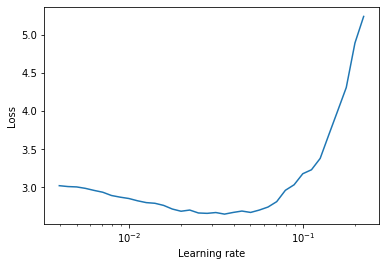

In [12]:
from torch_lr_finder import LRFinder
%run main_ResNet34.py

#training dataset
training_set = torch.utils.data.DataLoader(
torch.utils.data.ConcatDataset([
    datasets.ImageFolder(args.data + '/train_images',
                         transform=data_transforms),
    datasets.ImageFolder(args.data + '/train_images',
                         transform=data_transforms_2)]), batch_size=args.batch_size, shuffle=True, num_workers=1)


#Model
model = torchvision.models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 20)

# We freeze the 9 first layers
layer = 0
for name, child in model.named_children():
    layer += 1
    if layer <= 9:
        for name2, params in child.named_parameters():
            params.requires_grad = False

#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Criterion
criterion = nn.CrossEntropyLoss()

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader=training_set,val_loader=None, end_lr=100, num_iter=100)
lr_finder.plot()

In [13]:
lrs = lr_finder.history["lr"]#avoid the first small values
losses = lr_finder.history["loss"]

print('The smallest lost is :',np.min(losses),'reached for LR =',lrs[np.argmin(losses)])

The smallest lost is : 2.6455685305677323 reached for LR = 0.03548133892335755


#### 1.2.2 Train on 25 epochs with LR found
(rounded down to avoid skipping a good solution)

In [14]:
start=time.time()
%run main_ResNet34.py --epochs=25 --lr=0.01 --augmented=True --experiment=experiment

for epoch in range(1, args.epochs + 1):
    train(epoch)
    validation()
    model_file = args.experiment + '/model_ResNet34_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')

print('CPU- Time of execution :',time.time()-start,'s')  

Using GPU
Train Epoch: 1 [0/2164 (0%)]	Loss: 3.170176
Train Epoch: 1 [640/2164 (29%)]	Loss: 4.404844
Train Epoch: 1 [1280/2164 (59%)]	Loss: 2.108350
Train Epoch: 1 [1920/2164 (88%)]	Loss: 1.695557
Training set: Accuracy: 678/2164

Validation set: Average loss: 0.0265, Accuracy: 64/103 (62%)
Saved model to experiment/model_ResNet34_1.pth. You can run `python evaluate.py --model experiment/model_ResNet34_1.pth` to generate the Kaggle formatted csv file

Train Epoch: 2 [0/2164 (0%)]	Loss: 1.460911
Train Epoch: 2 [640/2164 (29%)]	Loss: 1.372950
Train Epoch: 2 [1280/2164 (59%)]	Loss: 1.091811
Train Epoch: 2 [1920/2164 (88%)]	Loss: 0.989077
Training set: Accuracy: 1311/2164

Validation set: Average loss: 0.0233, Accuracy: 64/103 (62%)
Saved model to experiment/model_ResNet34_2.pth. You can run `python evaluate.py --model experiment/model_ResNet34_2.pth` to generate the Kaggle formatted csv file

Train Epoch: 3 [0/2164 (0%)]	Loss: 0.995475
Train Epoch: 3 [640/2164 (29%)]	Loss: 0.752728
Train 

<Figure size 432x288 with 0 Axes>

#### 1.2.3 Train again starting from last best model (10th one)


c:\users\alixa\appdata\local\programs\python\python35\lib\site-packages\torchvision\transforms\transforms.py:220: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Using GPU


HBox(children=(IntProgress(value=0), HTML(value='')))

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


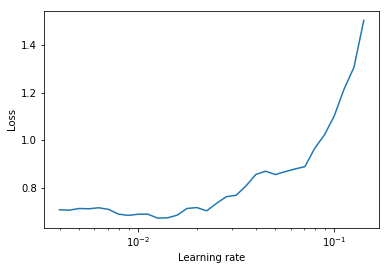

In [0]:
from torch_lr_finder import LRFinder
%run main_ResNet34.py

#training dataset
training_set = torch.utils.data.DataLoader(
torch.utils.data.ConcatDataset([
    datasets.ImageFolder(args.data + '/train_images',
                         transform=data_transforms),
    datasets.ImageFolder(args.data + '/train_images',
                         transform=data_transforms_2)]), batch_size=args.batch_size, shuffle=True, num_workers=1)


#Model
model = torchvision.models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 20)

# We freeze the 9 first layers
layer = 0
for name, child in model.named_children():
    layer += 1
    if layer <= 9:
        for name2, params in child.named_parameters():
            params.requires_grad = False
model.load_state_dict(torch.load('experiment/model_ResNet34_10.pth'))


#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Criterion
criterion = nn.CrossEntropyLoss()

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader=training_set,val_loader=None, end_lr=100, num_iter=100)
lr_finder.plot()

In [0]:
lrs = lr_finder.history["lr"]#avoid the first small values
losses = lr_finder.history["loss"]

print('The smallest lost is :',np.min(losses),'reached for LR =',lrs[np.argmin(losses)])

The smallest lost is : 0.6727173881476011 reached for LR = 0.012589254117941673


In [16]:
start=time.time()
%run main_ResNet34.py --epochs=25 --lr=0.001 --augmented=True --experiment=experiment_ResNet34

for epoch in range(1, args.epochs + 1):
    train(epoch)
    validation()
    model_file = args.experiment + '/model_ResNet34' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')

print('CPU- Time of execution :',time.time()-start,'s')  

Using GPU
Train Epoch: 1 [0/2164 (0%)]	Loss: 0.568656
Train Epoch: 1 [640/2164 (29%)]	Loss: 0.543444
Train Epoch: 1 [1280/2164 (59%)]	Loss: 0.620328
Train Epoch: 1 [1920/2164 (88%)]	Loss: 0.564063
Training set: Accuracy: 1788/2164

Validation set: Average loss: 0.0218, Accuracy: 69/103 (67%)
Saved model to experiment_ResNet34/model_ResNet341.pth. You can run `python evaluate.py --model experiment_ResNet34/model_ResNet341.pth` to generate the Kaggle formatted csv file

Train Epoch: 2 [0/2164 (0%)]	Loss: 0.392733
Train Epoch: 2 [640/2164 (29%)]	Loss: 0.469125
Train Epoch: 2 [1280/2164 (59%)]	Loss: 0.609272
Train Epoch: 2 [1920/2164 (88%)]	Loss: 0.435584
Training set: Accuracy: 1823/2164

Validation set: Average loss: 0.0217, Accuracy: 72/103 (70%)
Saved model to experiment_ResNet34/model_ResNet342.pth. You can run `python evaluate.py --model experiment_ResNet34/model_ResNet342.pth` to generate the Kaggle formatted csv file

Train Epoch: 3 [0/2164 (0%)]	Loss: 0.533797
Train Epoch: 3 [640/

#### 1.2.4 Saving best model

In [0]:
model.load_state_dict(torch.load('experiment_ResNet34/model_ResNet3412.pth'))
torch.save(model.state_dict(), 'experiment_ResNet34/best_model.pth')

We saved the model with best validation error and accuracy on the training :model9 to 'experiment/model_res18_saved1'.

Before experimenting on test, we retrain it on the full labeled dataset (training + validation).

## 2. Evaluate best model

### 2.1 Retrain saved model on augmented full labeled dataset 

HBox(children=(IntProgress(value=0), HTML(value='')))

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


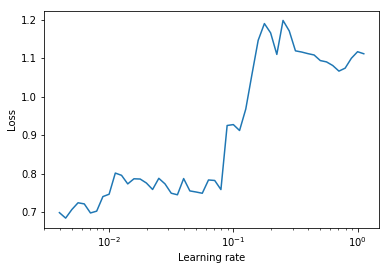

In [0]:
from torch_lr_finder import LRFinder


#training dataset
training_set = torch.utils.data.DataLoader(
torch.utils.data.ConcatDataset([
    datasets.ImageFolder(args.data + '/train_images',
                         transform=data_transforms),
    datasets.ImageFolder(args.data + '/train_images',
                         transform=data_transforms_2),
    datasets.ImageFolder(args.data + '/val_images',
                         transform=data_transforms),
    datasets.ImageFolder(args.data + '/val_images',
                         transform=data_transforms_2)]), batch_size=args.batch_size, shuffle=True, num_workers=1)


#Model
model = torchvision.models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 20)

# We freeze the 9 first layers
layer = 0
for name, child in model.named_children():
    layer += 1
    if layer <= 9:
        for name2, params in child.named_parameters():
            params.requires_grad = False

#Loading best model found in the previous step
model.load_state_dict(torch.load('experiment_ResNet34/best_model.pth'))


#Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Criterion
criterion = nn.CrossEntropyLoss()

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader=training_set,val_loader=None, end_lr=100, num_iter=100)
lr_finder.plot()

In [0]:
lrs = lr_finder.history["lr"]#avoid the first small values
losses = lr_finder.history["loss"]

print('The smallest lost is :',np.min(losses),'reached for LR =',lrs[np.argmin(losses)])

The smallest lost is : 0.4582690894603729 reached for LR = 0.0012589254117941673


In [18]:
start=time.time()
%run main_ResNet34.py --epochs=5  --lr=0.001 --train_all=True --experiment=experiment_ResNet34_full

for epoch in range(1, args.epochs + 1):
    train(epoch)
    #validation()
    model_file = args.experiment + '/model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')

print('CPU- Time of execution :',time.time()-start,'s')  

Using GPU
Train Epoch: 1 [0/2370 (0%)]	Loss: 0.516632
Train Epoch: 1 [640/2370 (26%)]	Loss: 0.653243
Train Epoch: 1 [1280/2370 (53%)]	Loss: 0.713585
Train Epoch: 1 [1920/2370 (79%)]	Loss: 0.561817
Training set: Accuracy: 1959/2370
Saved model to experiment_ResNet34_full/model_1.pth. You can run `python evaluate.py --model experiment_ResNet34_full/model_1.pth` to generate the Kaggle formatted csv file

Train Epoch: 2 [0/2370 (0%)]	Loss: 0.513675
Train Epoch: 2 [640/2370 (26%)]	Loss: 0.780144
Train Epoch: 2 [1280/2370 (53%)]	Loss: 0.364564
Train Epoch: 2 [1920/2370 (79%)]	Loss: 0.450628
Training set: Accuracy: 1957/2370
Saved model to experiment_ResNet34_full/model_2.pth. You can run `python evaluate.py --model experiment_ResNet34_full/model_2.pth` to generate the Kaggle formatted csv file

Train Epoch: 3 [0/2370 (0%)]	Loss: 0.369426
Train Epoch: 3 [640/2370 (26%)]	Loss: 0.686823
Train Epoch: 3 [1280/2370 (53%)]	Loss: 1.008711
Train Epoch: 3 [1920/2370 (79%)]	Loss: 0.544806
Training set:

### 2.2 Save best model trained on full dataset

In [0]:
model.load_state_dict(torch.load('experiment_ResNet34_full/model_3.pth'))
torch.save(model.state_dict(), 'experiment_ResNet34_full/best_model.pth')

### 2.3 Generate predictions on test set with retrained best model


In [21]:
%run evaluate_ResNet34.py --model=experiment_ResNet34_full/best_model.pth --outfile=Results/ResNet34.csv

Using GPU


100%|██████████| 289/289 [02:26<00:00,  2.12it/s]

Succesfully wrote Results/ResNet34.csv, you can upload this file to the kaggle competition website
